<a href="https://colab.research.google.com/github/lightdiffraction/sem6_nnlabs/blob/main/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy
import math
from keras import backend as K

In [ ]:
# генерация тестовых данных
x = torch.linspace(-5,5, 120)
# Z-Score Normalization
mean = x.mean(dim=0, keepdim=True)
std = x.std(dim=0, keepdim=True)
x = (x - mean) / std

In [ ]:
# функция для аппроксимации
f = lambda x: torch.exp(-x*x)+0.1*torch.cos(10*x)

In [ ]:
# первый вариант сети
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.hidden1 = torch.nn.Linear(1, 64)
    self.output = torch.nn.Linear(64, 1)
    torch.nn.init.xavier_normal_(self.hidden1.weight)
    torch.nn.init.zeros_(self.hidden1.bias)

  def forward(self, x):
    x = torch.relu(self.hidden1(x))
    x = self.output(x)
    return x

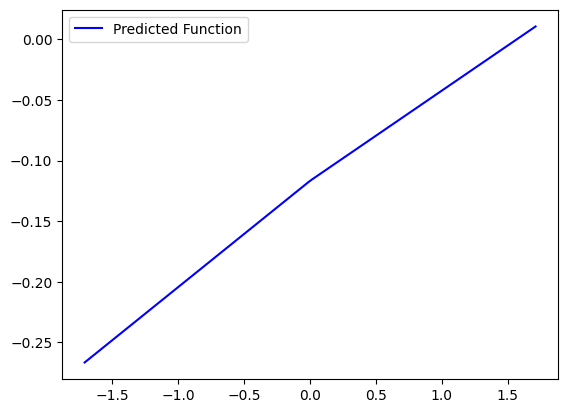

In [ ]:
net = Net()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.04) # Using Adam

mean = torch.mean(torch.tensor([f(p) for p in x]))
std = torch.std(torch.tensor([f(p) for p in x]))
actual_y = (torch.tensor([f(p) for p in x])-mean)/std

#валидационная выборка
x_val = torch.linspace(-5,5, 60)
# Z-Score Normalization
mean = x_val.mean(dim=0, keepdim=True)
std = x_val.std(dim=0, keepdim=True)
x_val = (x_val - mean) / std
mean = torch.mean(torch.tensor([f(p) for p in x_val]))
std = torch.std(torch.tensor([f(p) for p in x_val]))
y_val = (torch.tensor([f(p) for p in x_val])-mean)/std

#тестовая выборка
x_test = torch.linspace(-5,5, 20)
# Z-Score Normalization
mean = x_test.mean(dim=0, keepdim=True)
std = x_test.std(dim=0, keepdim=True)
x_test = (x_test - mean) / std
mean = torch.mean(torch.tensor([f(p) for p in x_test]))
std = torch.std(torch.tensor([f(p) for p in x_test]))
y_test = (torch.tensor([f(p) for p in x_test])-mean)/std

#массивы ошибок для графиков
loss_graph = []
val_loss_graph = []
test_loss_graph = []

predicted_y = net(x.unsqueeze(1)).squeeze()
#plt.plot(x, actual_y, 'g', label='Actual Function')
plt.plot(x, predicted_y.detach().numpy(), 'b', label='Predicted Function')
plt.legend()
plt.show()

<ipython-input-480-5cda1f14e37b>:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


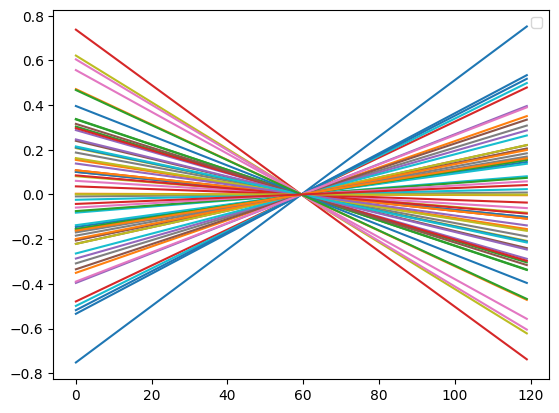

In [ ]:
hidden_outputs = net.hidden1(x.unsqueeze(1))
plt.plot(hidden_outputs.detach().numpy())
plt.legend()
plt.show()

Epoch 0: Loss = 1.0067176818847656
Epoch 100: Loss = 0.036300159990787506
Epoch 200: Loss = 0.033232659101486206
Epoch 300: Loss = 0.030290305614471436
Epoch 400: Loss = 0.031755898147821426
Epoch 500: Loss = 0.02808411978185177
Epoch 600: Loss = 0.04480186849832535
Epoch 700: Loss = 0.04885014519095421
Epoch 800: Loss = 0.028243759647011757
Epoch 900: Loss = 0.02518037147819996


<ipython-input-481-fd3837f6325d>:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


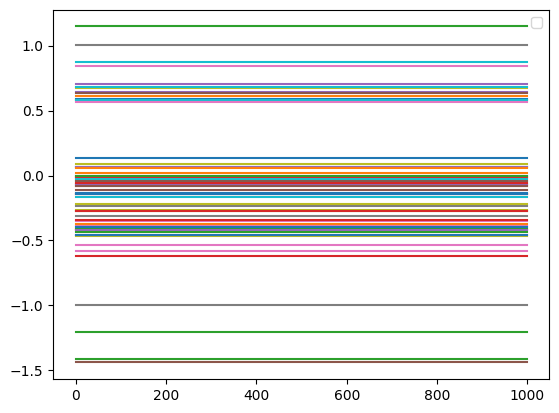

In [ ]:
# обучение
stop_criterion = 0
weights_dynamic = []
output_dynamic = []
for epoch in range(1000):
 running_loss = 0.0
 optimizer.zero_grad()
 outputs = net(x.unsqueeze(1))
 # присоединение весов на данном этапе к массиву с изменением весов во времени
 weights_dynamic.append(net.hidden1.weight.detach().numpy())
 output_dynamic.append(net.output.weight.detach().numpy())
 loss = criterion(outputs.squeeze(), actual_y)
 current_loss = loss.detach().numpy()
 loss_graph.append(current_loss)
 loss.backward()
 optimizer.step()
 running_loss += loss.item()

# подсчет ошибки на валидационной выборке
 val_outputs = net(x_val.unsqueeze(1))
 val_loss = criterion(val_outputs.squeeze(), y_val)

 current_val_loss = val_loss.detach().numpy()
 if val_loss_graph:
  if current_val_loss > val_loss_graph[-1]:
   stop_criterion += 1
  else:
   stop_criterion = 0
 if stop_criterion >= 20:
  break

 val_loss_graph.append(val_loss.detach().numpy())

 test_outputs = net(x_test.unsqueeze(1))
 test_loss = criterion(test_outputs.squeeze(), y_test)
 test_loss_graph.append(test_loss.detach().numpy())

 if epoch % 100 == 0:
  print("Epoch {}: Loss = {}".format(epoch, loss.detach().numpy()))

nparrtest = numpy.array(weights_dynamic).squeeze()
plt.plot(numpy.array(weights_dynamic).squeeze())
plt.legend()
plt.show()

<ipython-input-482-06e1358b3cee>:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


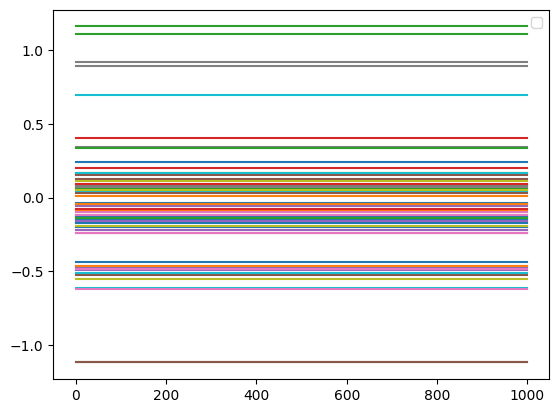

In [ ]:
plt.plot(numpy.array(output_dynamic).squeeze())
plt.legend()
plt.show()

In [ ]:
# макс. абс. ошибка
max(abs(actual_y - outputs.squeeze())).detach().numpy(),  max(abs(y_val - val_outputs.squeeze())).detach().numpy(), max(abs(y_test - test_outputs.squeeze())).detach().numpy()

(array(0.36599836, dtype=float32),
 array(0.35942706, dtype=float32),
 array(0.32271725, dtype=float32))

In [ ]:
#СКО ошибки
(actual_y - outputs.squeeze()).detach().numpy().std(), (y_val - val_outputs.squeeze()).detach().numpy().std(), (y_test - test_outputs.squeeze()).detach().numpy().std()

(np.float32(0.15780444), np.float32(0.15688461), np.float32(0.15359293))

In [ ]:
# RMSE
math.sqrt(loss.detach().numpy()), math.sqrt(val_loss.detach().numpy()), math.sqrt(test_loss.detach().numpy())

(0.1578115515161093, 0.15695469019533304, 0.15633343614652476)

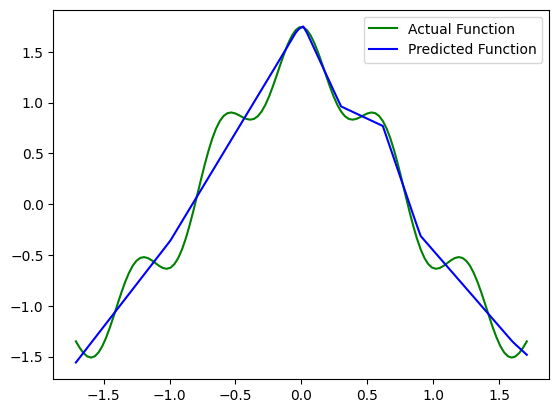

In [ ]:
#x_plot = torch.linspace(-5,5, 120)
#actual_y = torch.tensor([f(p) for p in x_plot])
predicted_y = net(x.unsqueeze(1)).squeeze()
plt.plot(x, actual_y, 'g', label='Actual Function')
plt.plot(x, predicted_y.detach().numpy(), 'b', label='Predicted Function')
plt.legend()
plt.show()

In [ ]:
#На валидационной выборке
for epoch in range(100):
 running_loss = 0.0
 optimizer.zero_grad()
 outputs = net(x_val.unsqueeze(1))
 loss = criterion(outputs.squeeze(), y_val)
 loss.backward()
 optimizer.step()
 running_loss += loss.item()

 if epoch % 10 == 0:
  print("Epoch {}: Loss = {}".format(epoch, loss.detach().numpy()))

Epoch 0: Loss = 0.024634774774312973
Epoch 10: Loss = 0.03255564346909523
Epoch 20: Loss = 0.026742691174149513
Epoch 30: Loss = 0.025385303422808647
Epoch 40: Loss = 0.024935483932495117
Epoch 50: Loss = 0.024473583325743675
Epoch 60: Loss = 0.024891158565878868
Epoch 70: Loss = 0.03627533093094826
Epoch 80: Loss = 0.029717981815338135
Epoch 90: Loss = 0.024718288332223892


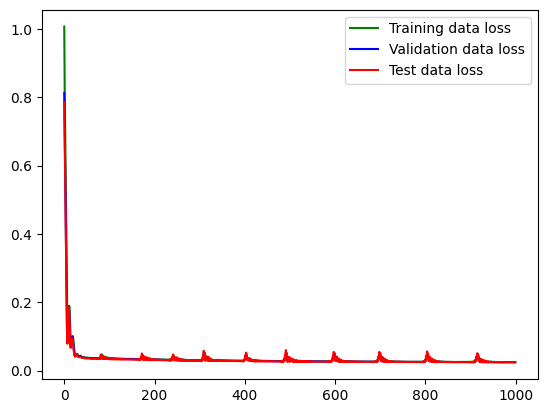

In [ ]:
plt.plot(loss_graph, 'g', label='Training data loss')
plt.plot(val_loss_graph, 'b', label='Validation data loss')
plt.plot(test_loss_graph, 'r', label='Test data loss')
plt.legend()
plt.show()

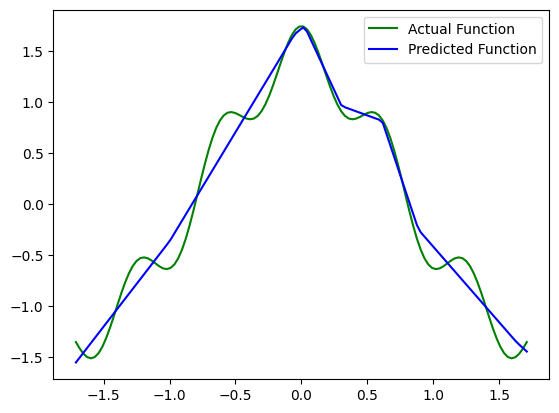

In [ ]:
#x_plot = torch.linspace(-5,5, 120)
#actual_y = torch.tensor([f(p) for p in x_plot])
predicted_y = net(x.unsqueeze(1)).squeeze()
plt.plot(x, actual_y, 'g', label='Actual Function')
plt.plot(x, predicted_y.detach().numpy(), 'b', label='Predicted Function')
plt.legend()
plt.show()

<ipython-input-490-5cda1f14e37b>:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


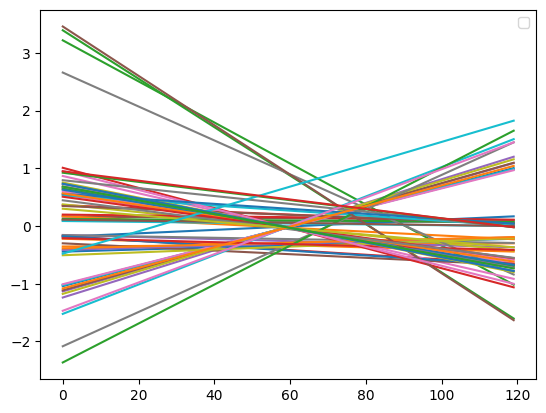

In [ ]:
hidden_outputs = net.hidden1(x.unsqueeze(1))
plt.plot(hidden_outputs.detach().numpy())
plt.legend()
plt.show()

In [ ]:
class Net2(torch.nn.Module):
  def __init__(self):
    super(Net2, self).__init__()
    self.hidden1 = torch.nn.Linear(1, 128) # 1 neuron in input layer, 64 neurons in 1st hidden layer 1
    # self.hidden2 = torch.nn.Linear(64, 128) # 128 neurons in 2nd hidden layer
    self.output = torch.nn.Linear(128, 1) # 1 neuron in output layer
    torch.nn.init.xavier_normal_(self.hidden1.weight)
    torch.nn.init.zeros_(self.hidden1.bias)

  def forward(self, x):
    x = torch.tanh(self.hidden1(x))
    #x = torch.relu(self.hidden2(x))
    x = self.output(x)
    return x

In [ ]:
net = Net2()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.04)
for epoch in range(10000):
 running_loss = 0.0
 optimizer.zero_grad()
 outputs = net(x.unsqueeze(1))
  #Z-Score Normalization
# mean = f(x).mean(dim=0, keepdim=True)
# std = f(x).std(dim=0, keepdim=True)
# f_x = (f(x) - mean) / std
 loss = criterion(outputs.squeeze(), actual_y)
 loss_graph.append(loss.detach().numpy())
 loss.backward()
 optimizer.step()
 running_loss += loss.item()

 val_outputs = net(x_val.unsqueeze(1))
 val_loss = criterion(val_outputs.squeeze(), y_val)
 current_val_loss = val_loss.detach().numpy()
 if val_loss_graph:
  if current_val_loss > val_loss_graph[-1]:
   stop_criterion += 1
  else:
   stop_criterion = 0
 if stop_criterion >= 20:
  break

 val_loss_graph.append(val_loss.detach().numpy())

 test_outputs = net(x_test.unsqueeze(1))
 test_loss = criterion(test_outputs.squeeze(), y_test)
 test_loss_graph.append(test_loss.detach().numpy())

 if epoch % 1000 == 0:
  print("Epoch {}: Loss = {}".format(epoch, loss.detach().numpy()))

Epoch 0: Loss = 0.9976304173469543
Epoch 1000: Loss = 0.03854246437549591
Epoch 2000: Loss = 0.03828679397702217
Epoch 3000: Loss = 0.03619888797402382
Epoch 4000: Loss = 0.015109594911336899
Epoch 5000: Loss = 0.009420013055205345
Epoch 6000: Loss = 0.008007552474737167
Epoch 7000: Loss = 0.005283117759972811
Epoch 8000: Loss = 0.0015354692004621029
Epoch 9000: Loss = 0.008450483903288841


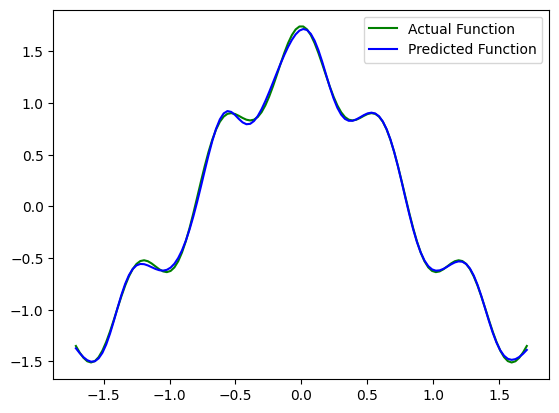

In [ ]:
#x_plot = torch.linspace(-5,5, 120)
#actual_y = torch.tensor([f(p) for p in x_plot])
predicted_y = net(x.unsqueeze(1)).squeeze()
plt.plot(x, actual_y, 'g', label='Actual Function')
plt.plot(x, predicted_y.detach().numpy(), 'b', label='Predicted Function')
plt.legend()
plt.show()


In [ ]:
# макс. абс. ошибка
max(abs(actual_y - outputs.squeeze())).detach().numpy(),  max(abs(y_val - val_outputs.squeeze())).detach().numpy(), max(abs(y_test - test_outputs.squeeze())).detach().numpy()

(array(0.05248082, dtype=float32),
 array(0.05198634, dtype=float32),
 array(0.08482832, dtype=float32))

In [ ]:
#СКО ошибки
(actual_y - outputs.squeeze()).detach().numpy().std(), (y_val - val_outputs.squeeze()).detach().numpy().std(), (y_test - test_outputs.squeeze()).detach().numpy().std()

(np.float32(0.020853242), np.float32(0.02077784), np.float32(0.02696816))

In [ ]:
# RMSE
math.sqrt(loss.detach().numpy()), math.sqrt(val_loss.detach().numpy()), math.sqrt(test_loss.detach().numpy())

(0.021236281602649433, 0.020914253011474534, 0.036109065938870734)